### Importy

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import optuna
import tensorflow as tf
import numpy as np
from scripts.train_utilities import *
from scripts.essentials import *
from tensorflow.keras.callbacks import EarlyStopping
from scripts.plots import *
import random
from pickle import load
from plots import *
from sklearn.metrics import roc_auc_score
from scipy.special import expit

In [ ]:
#tf.compat.v1.disable_v2_behavior()

In [87]:
prefix = "TSLA"

In [88]:
if prefix == 'BTC-USD':
  df = pd.read_csv(f'{prefix}_with_weekends.csv')
  step = 7
else:
  df = pd.read_csv(f'{prefix}_without_weekends.csv')
  step = 5

cols_min_max = ['^GSPC_Volume', prefix+'_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

scaler_min_max = load(open(f'scaler/scaler_min_max_{prefix}.pkl', 'rb'))
df = min_max_scale(df,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

if prefix == 'BTC-USD':
  df['target_7'] = df['log_return_7'].shift(-7)


else:
  df['target_1'] = df['log_return_1'].shift(-1)
  df['target_5'] = df['log_return_5'].shift(-5)

df = df[df['Date']>= '2021-01-01'].reset_index(drop=True)

### Optuna

In [5]:
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [6]:
def objective(trial):
    model = create_model(trial, input_shape=(X.shape[1], X.shape[2]))

    early_stopping = EarlyStopping(monitor='val_custom_auc', patience=35, mode='max', restore_best_weights=True)

    history = model.fit(X, y, epochs=200, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    number = random.randint(1,10000)
    print(number)
    model.save(f'models/{prefix}/{number}_lstm.h5')
    val_loss, val_score = model.evaluate(X_val, y_val, verbose=0)
    return val_score

In [7]:
def window_dataset(df, target_column, window_size,):
    X = []
    y = []

    # Iterate over the dataset
    for i in range(len(df) - window_size):
        # Extract the window of data
        window = df[i:i+window_size]

        # Extract the features (X) and target (y)
        X.append(window.drop(columns=[target_column]).values)
        y.append(df[target_column][i+window_size])


    return np.array(X), np.array(y)

In [ ]:
# Dane finansowe
window_size = 10
target_cols = ['target_5']
cols_used = [
             'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14'
             ]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_f = optuna.create_study(direction='maximize')
study_f.optimize(objective, n_trials=15)

print(study_f.best_params)

In [ ]:
# Dane newsowe
window_size = 10
target_cols = ['target_5']
cols_used = [
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_n = optuna.create_study(direction='maximize')
study_n.optimize(objective, n_trials=15)

print(study_n.best_params)

In [ ]:
# Pełne dane
window_size = 10
target_cols = ['target_5']
cols_used = [
            'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14' ,
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_full = optuna.create_study(direction='maximize')
study_full.optimize(objective, n_trials=15) 

print(study_full.best_params)

### Model Finance

In [11]:
window_size = 10
target_cols = ['target_5']
cols_used = [
             'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14'
             ]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_f.best_params, X, y, X_val, y_val)

In [65]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [66]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.5558954100466954
0.578125
0.32142857142857145


In [67]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[180 149]
 [134 183]]
val
[[ 5 11]
 [ 9 15]]
test
[[10 18]
 [18  9]]


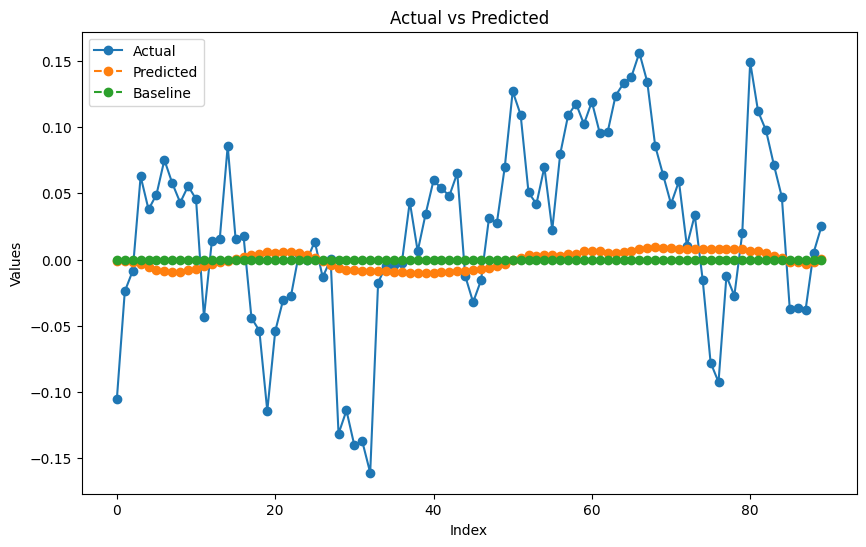

In [68]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, [0 for i in range(y.shape[0])][k:])

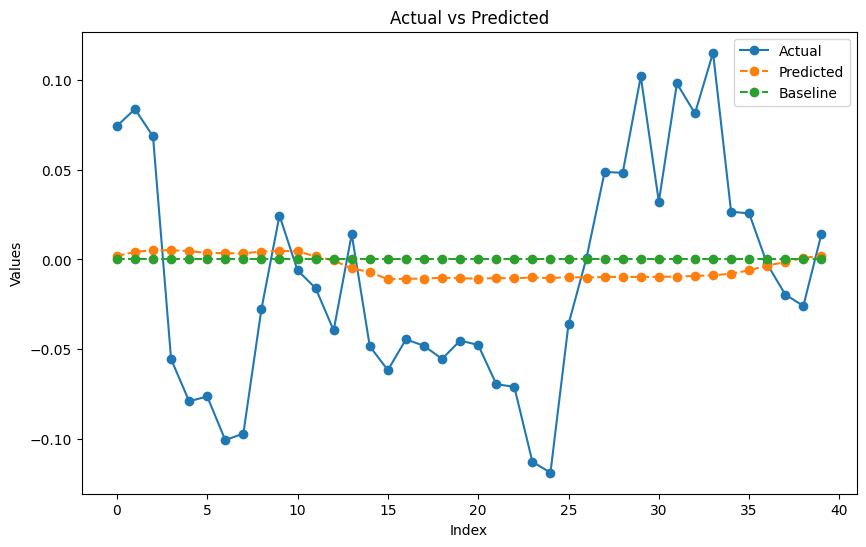

In [69]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

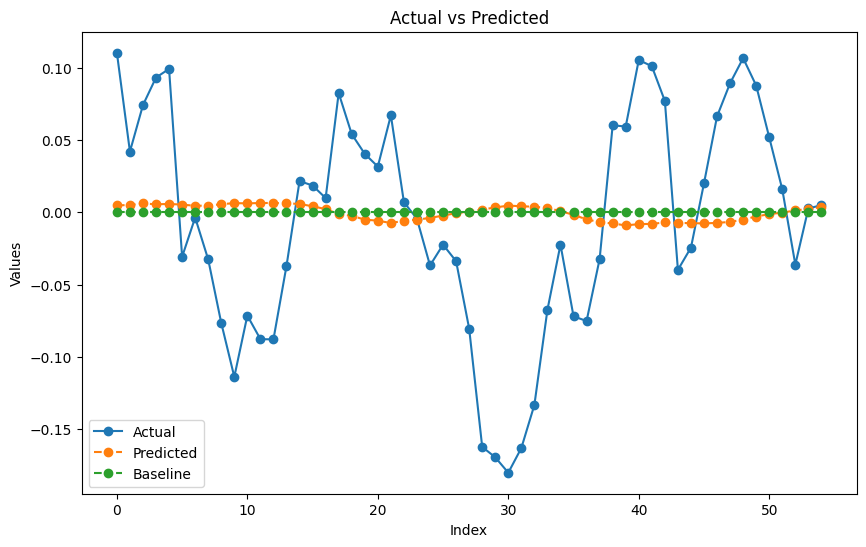

In [70]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [72]:
model.save(prefix+'_lstm_fin_cols.h5')

### Model News

In [134]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_n.best_params, X, y, X_val, y_val)

In [140]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [141]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.7543075757721035
0.8229166666666667
0.4973544973544973


In [142]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[201 128]
 [ 85 232]]
val
[[13  3]
 [ 7 17]]
test
[[ 9 19]
 [10 17]]


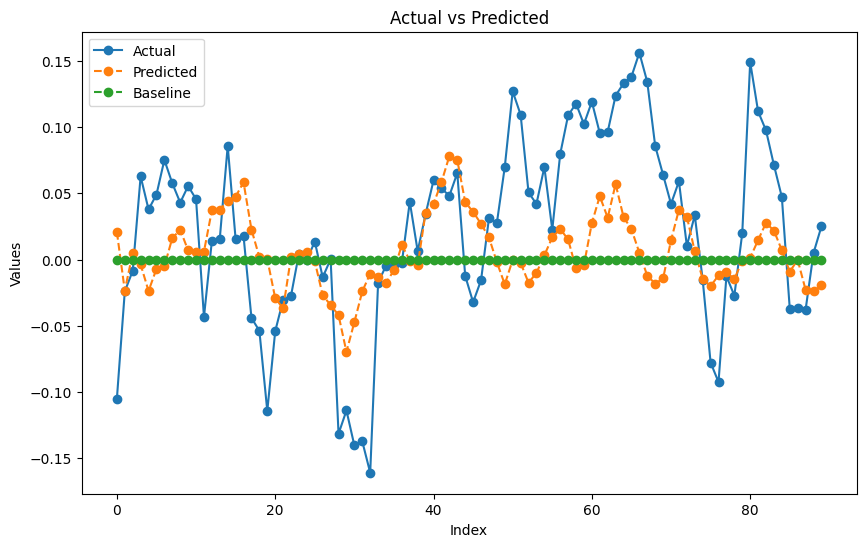

In [143]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

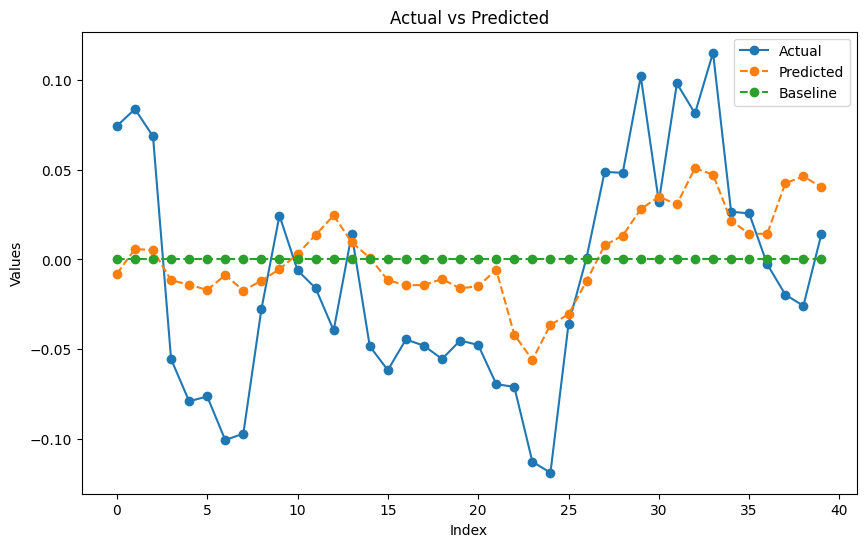

In [144]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

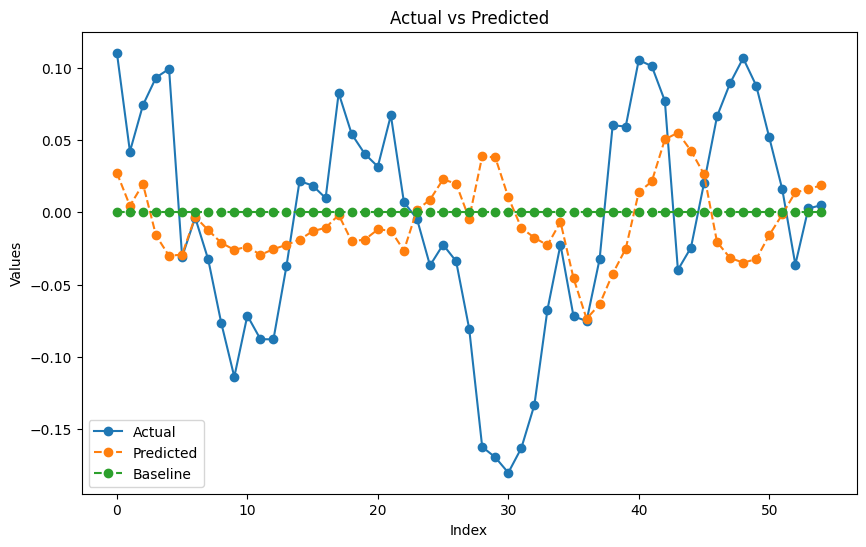

In [145]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [ ]:
model.save(prefix+'_lstm_news_cols.h5')

### Model Full

In [106]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14' ,
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_full.best_params, X, y, X_val, y_val)

In [115]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [116]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.9043847621604518
0.828125
0.43121693121693117


In [117]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[224 105]
 [ 27 290]]
val
[[10  6]
 [ 4 20]]
test
[[ 7 21]
 [13 14]]


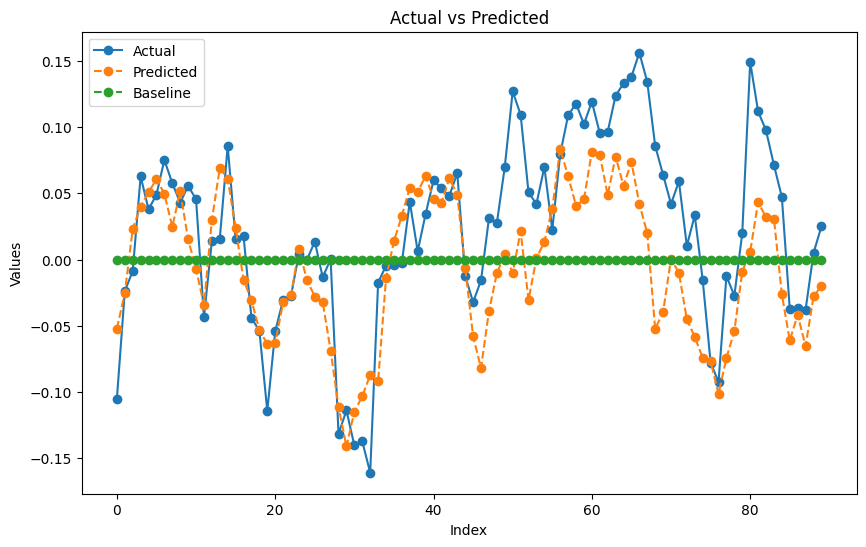

In [118]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

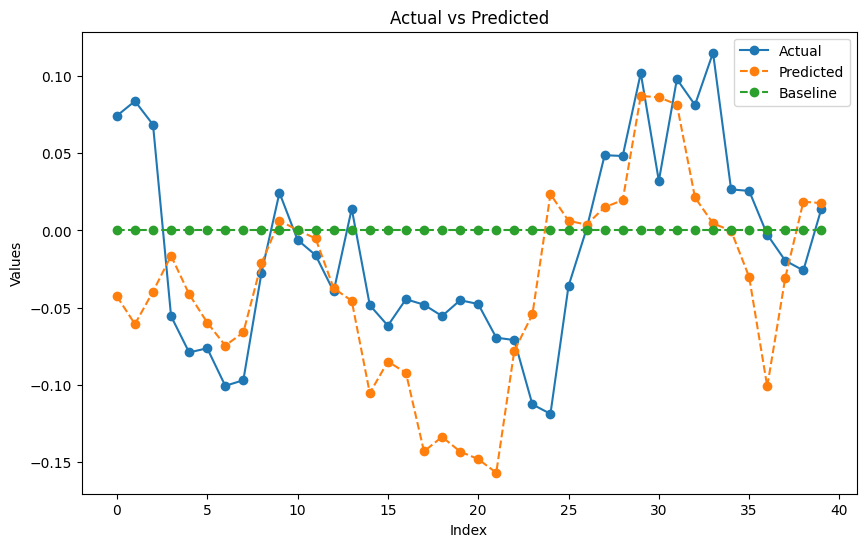

In [119]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

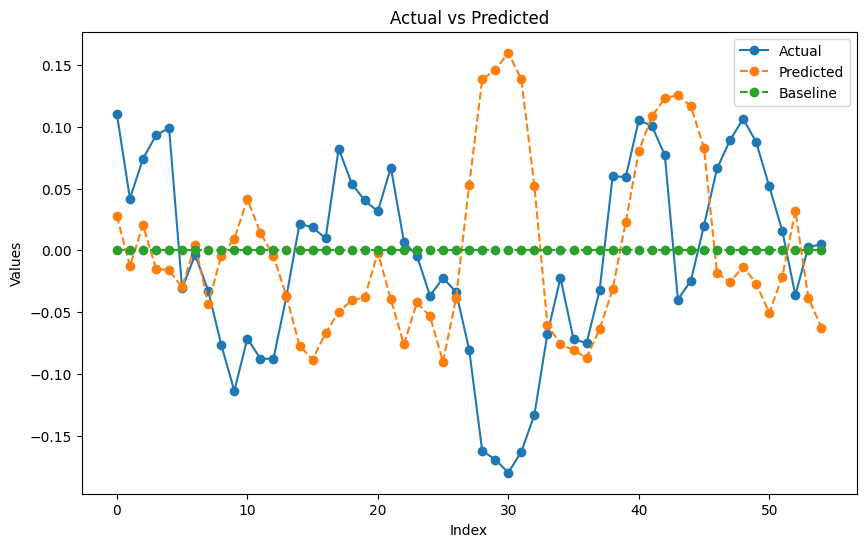

In [120]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [122]:
model.save(prefix+'_lstm_full_cols.h5')